In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# setup
import torch

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

#import MNIST
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

In [ ]:
# download training data mask and testing data
test_data = torch.load(f'/content/gdrive/My Drive/Research/datasets/test_data10000.pth')
train_data = torch.load(f'/content/gdrive/My Drive/Research/train_data100.pth')
train_data_orig = torch.load(f'/content/gdrive/My Drive/Research/datasets/train_data_orig.pth')
train_orig_100 = torch.utils.data.Subset(train_data_orig, train_data.indices)

# download validation data
validation_data = torch.load(f'/content/gdrive/My Drive/Research/datasets/validation_data.pth')

x, y = train_data[0]
print(x.shape, y)
print(train_data.indices)

torch.Size([1, 28, 28]) 0
[1, 21, 34, 37, 51, 30009, 30034, 30037, 30044, 30051, 3, 6, 8, 14, 23, 30007, 30031, 30035, 30043, 30047, 5, 16, 25, 28, 76, 30014, 30027, 30032, 30054, 30055, 7, 10, 12, 27, 30, 30000, 30002, 30011, 30040, 30041, 2, 9, 20, 26, 53, 30005, 30006, 30016, 30039, 30052, 0, 11, 35, 47, 65, 30012, 30020, 30028, 30030, 30042, 13, 18, 32, 36, 39, 30004, 30023, 30024, 30025, 30033, 15, 29, 38, 42, 52, 30001, 30008, 30015, 30017, 30018, 17, 31, 41, 46, 55, 30013, 30019, 30026, 30029, 30038, 4, 19, 22, 33, 43, 30003, 30010, 30022, 30049, 30069]


In [ ]:
# download all 50 augmented datasets, mask to 100 examples, store
augmented_datasets_100 = {}
ds_names = ["train_data_scaling", "train_data_randCrop", "train_data_distortion", "train_data_blur", "train_data_erasing"]
for i in range(10):
  for ds in ds_names:
    key = ds + '_' + str(i)
    path = '/content/gdrive/My Drive/Research/datasets/' + ds + '/' + key + '.pth'
    dataset = torch.load(path)
    subset_100 = torch.utils.data.Subset(dataset, train_data.indices)
    augmented_datasets_100[key] = subset_100

In [ ]:
# visualize some datasets
import matplotlib.pyplot as plt

# # compare firt 25 images
# test_ind = range(0, 25)
# print(test_ind)

# # compare 5 images randomly
# import random
# test_ind = random.sample(range(100), 5)
# # print(test_ind)

count = 0
for ds in augmented_datasets_100:
  count += 1
  if count >= 6: break

  print("Printing examples from " + ds)
  figure = plt.figure(figsize=(10, 8))
  cols, rows = 1, 5
  dataset = augmented_datasets_100[ds]
  for i in range(1, cols * rows + 1):
      sample_idx = test_ind[i - 1]
      img, label = dataset[sample_idx]
      figure.add_subplot(rows, cols, i)
      plt.title(label)
      plt.axis("off")
      plt.imshow(img.squeeze(), cmap="gray")
  plt.show()


# print original
print("Printing examples from original")
figure = plt.figure(figsize=(10, 8))
cols, rows = 1, 5
dataset = train_orig_100
for i in range(1, cols * rows + 1):
    sample_idx = test_ind[i - 1]
    img, label = train_orig_100[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Printing examples from train_data_scaling_0


NameError: ignored

<Figure size 720x576 with 0 Axes>

In [ ]:
# concat the datasets - 5 total datasets
concated_datasets = {}
for name in ds_names:
  datasets_list = [train_orig_100]
  for key in augmented_datasets_100:
    if key[:len(name)] == name:
      datasets_list.append(augmented_datasets_100[key])
  merged_dataset = torch.utils.data.ConcatDataset(datasets_list)
  concated_datasets[name] = merged_dataset

# add the original
orig_11 = [train_orig_100] * 11
concated_datasets['train_orig_100'] = torch.utils.data.ConcatDataset(orig_11)

In [ ]:
for key in concated_datasets:
  ds = concated_datasets[key]
  print(type(ds))
  print(len(ds))
  print(type(ds[0]))
  x, y = ds[0]
  print(type(x))
  print(type(y))

<class 'torch.utils.data.dataset.ConcatDataset'>
1100
<class 'tuple'>
<class 'torch.Tensor'>
<class 'int'>
<class 'torch.utils.data.dataset.ConcatDataset'>
1100
<class 'tuple'>
<class 'torch.Tensor'>
<class 'int'>
<class 'torch.utils.data.dataset.ConcatDataset'>
1100
<class 'tuple'>
<class 'torch.Tensor'>
<class 'int'>
<class 'torch.utils.data.dataset.ConcatDataset'>
1100
<class 'tuple'>
<class 'torch.Tensor'>
<class 'int'>
<class 'torch.utils.data.dataset.ConcatDataset'>
1100
<class 'tuple'>
<class 'torch.Tensor'>
<class 'int'>
<class 'torch.utils.data.dataset.ConcatDataset'>
1100
<class 'tuple'>
<class 'torch.Tensor'>
<class 'int'>


In [ ]:
def load_data(ds):
  loaders = {
    'train' : torch.utils.data.DataLoader(merged_dataset, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=1000, 
                                          shuffle=True, 
                                          num_workers=1),
    'validation' : torch.utils.data.DataLoader(validation_data, 
                                          batch_size=1000, 
                                          shuffle=True, 
                                          num_workers=1),
  }
  return loaders

In [ ]:
# define our CNN
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization


In [ ]:
def validate():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['validation']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
    print('Validation Accuracy of the model on the 10000 validation images: %.2f' % accuracy)
    return accuracy
    pass

In [ ]:
# testing
def test(cnn):
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    return accuracy
    
    pass

In [ ]:
from pickle import bytes_types
from torch.autograd import Variable

def train(num_epochs, cnn, loaders):
    # to return
    best_model = None
    best_val = -1
    loss_list = []
    validation_acc_list = []

    cnn.train()
    total_step = 10  # 1100 epochs, 100 each batch
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            # break if steps met
            if i >= total_step: continue
            else:
              # gives batch data, normalize x when iterate train_loader
              b_x = Variable(images)   # batch x size batch_size
              b_y = Variable(labels)   # batch y
              output = cnn(b_x)[0]               
              loss = loss_func(output, b_y)
              
              # clear gradients for this training step   
              optimizer.zero_grad()           
              
              # backpropagation, compute gradients 
              loss.backward()    
              # apply gradients             
              optimizer.step()       
              
              # if (i+1) % 100 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                        .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
              
              # append loss
              num = float(str(epoch) + '.' + str(i))
              loss_list.append((num, loss.item()))
              pass
        
        # log validation loss
        val_acc = validate()
        validation_acc_list.append((epoch + 1, val_acc))
        if val_acc > best_val:
          best_model = cnn
          best_val = val_acc
        pass

    return best_model, best_val, loss_list, validation_acc_list
    
    
    pass

In [ ]:
from torch.utils.data import DataLoader
# we will gather all training loss and validation acc while training
# containing 1) loss list 2) test accuracy 3) validation loss list 4) max validation accuracy
results = {}
to_evaluate = ds_names + ["train_orig_100"]

for ds in to_evaluate:
  merged_dataset = concated_datasets[ds]
  loaders = load_data(merged_dataset)
  # torch.cuda.empty_cache() 
  # define loss function and optimizer, initialize network
  loss_func = nn.CrossEntropyLoss()   
  from torch import optim
  cnn = CNN()
  optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
  loss_list = []
  validation_acc_list = []

  # train the model
  num_epochs = 30
  best_model, best_val, loss_list, val_list = train(num_epochs, cnn, loaders)
  test_acc = test(best_model)
  results[ds] = best_model, loss_list, val_list, best_val, test_acc

Epoch [1/30], Step [1/10], Loss: 2.3059
Epoch [1/30], Step [2/10], Loss: 2.6572
Epoch [1/30], Step [3/10], Loss: 2.3474
Epoch [1/30], Step [4/10], Loss: 2.2992
Epoch [1/30], Step [5/10], Loss: 2.3071
Epoch [1/30], Step [6/10], Loss: 2.3005
Epoch [1/30], Step [7/10], Loss: 2.2974
Epoch [1/30], Step [8/10], Loss: 2.2993
Epoch [1/30], Step [9/10], Loss: 2.2812
Epoch [1/30], Step [10/10], Loss: 2.2825
Validation Accuracy of the model on the 10000 validation images: 0.32
Epoch [2/30], Step [1/10], Loss: 2.2408
Epoch [2/30], Step [2/10], Loss: 2.2296
Epoch [2/30], Step [3/10], Loss: 2.1932
Epoch [2/30], Step [4/10], Loss: 2.1947
Epoch [2/30], Step [5/10], Loss: 2.0929
Epoch [2/30], Step [6/10], Loss: 2.0692
Epoch [2/30], Step [7/10], Loss: 1.9057
Epoch [2/30], Step [8/10], Loss: 1.8590
Epoch [2/30], Step [9/10], Loss: 1.7511
Epoch [2/30], Step [10/10], Loss: 1.6967
Validation Accuracy of the model on the 10000 validation images: 0.57
Epoch [3/30], Step [1/10], Loss: 1.6428
Epoch [3/30], Step

In [ ]:
def save_data(dataset, name):
  path = f'/content/gdrive/My Drive/Research/results/{name}.pth'
  print(f'Saving {name} model...')
  torch.save(dataset, path)
  print(f'{name} saved successfully.')

In [ ]:
# save results
save_data(results, 'results_05182022')

Saving results_05182022 model...
results_05182022 saved successfully.


In [ ]:
# visualize results
results = torch.load(f'/content/gdrive/My Drive/Research/results/results_05182022.pth')

In [ ]:
# check the format of results - should be models
for model_name in results:
  print(model_name)
  model = results[model_name][0]
  print(type(model))

train_data_scaling
<class '__main__.CNN'>
train_data_randCrop
<class '__main__.CNN'>
train_data_distortion
<class '__main__.CNN'>
train_data_blur
<class '__main__.CNN'>
train_data_erasing
<class '__main__.CNN'>
train_orig_100
<class '__main__.CNN'>


In [ ]:
for key in results:
  _, loss_list, val_list, best_val, test_acc = results[key]
  # losses.append(loss_list)
  # vals.append(val_list)
  # print(test_acc)
  print(key, "// best_val is", best_val, "test_acc is", test_acc)


train_data_scaling // best_val is 0.762 test_acc is 0.72
train_data_randCrop // best_val is 0.903 test_acc is 0.891
train_data_distortion // best_val is 0.846 test_acc is 0.85
train_data_blur // best_val is 0.793 test_acc is 0.766
train_data_erasing // best_val is 0.853 test_acc is 0.835
train_orig_100 // best_val is 0.804 test_acc is 0.825


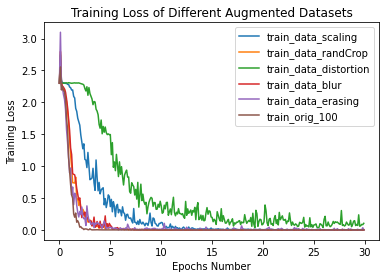

In [ ]:
import matplotlib.pyplot as plt

for key in results:
  _, loss_list, val_list, best_val, test_acc = results[key]
  # losses.append(loss_list)
  # vals.append(val_list)
  # print(test_acc)
  list1, list2 = map(list, zip(*loss_list))
  plt.plot(list1, list2, label = str(key))
  plt.legend()


plt.title('Training Loss of Different Augmented Datasets')
plt.xlabel('Epochs Number')
plt.ylabel('Training Loss')
plt.show()


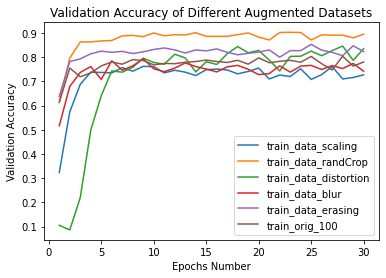

In [ ]:
for key in results:
  _, loss_list, val_list, best_val, test_acc = results[key]
  # losses.append(loss_list)
  # vals.append(val_list)
  # print(test_acc)
  list1, list2 = map(list, zip(*val_list))
  plt.plot(list1, list2, label = str(key))
  plt.legend()


plt.title('Validation Accuracy of Different Augmented Datasets')
plt.xlabel('Epochs Number')
plt.ylabel('Validation Accuracy')
plt.show()